In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import warnings
warnings.filterwarnings("ignore")

# Process datasets

## Define code to handle differences in omics datasets

### General

In [13]:
EARLY_THRESHOLD = 6

def select_feature_above_variance(data:pd.DataFrame, variance_threshold=1) -> list:
    accept = []
    for c in data.columns:
        c_var = data[c].var()
        if c_var < variance_threshold:
            #print(f"{c} - {c_var}<{variance_threshold}")
            continue
        else:
            accept.append(c)
    return accept

def parse_group(index):
    return str(index).split("_")[0]

def parse_time(index):
    return int(str(index).split("_")[1][0:-1])

def parse_time_class(index):
    group = parse_group(index)
    time = parse_time(index)

    return f"{group}_early" if time <=6 else f"{group}_late"

### Column name transformers

In [14]:
# transformer for proteomics sample names
def prot_sample_name_transformer(columns:list) -> list:
    col_new = []
    count_dict = {}
    for c in columns:
        base = "_".join(str(c).lower().split("_")[0:-1])
        if base in count_dict:
            # in counting dictionary
            count_dict[base] += 1
        else:
            # not in counting dictionary
            count_dict[base] = 1
        col_new.append(f"{base}_{count_dict[base]}")
        
    return col_new

# transformer for metabolomics sample names
def met_sample_name_transformer(columns:list) -> list:
    col_new = []
    count_dict = {}
    for c in columns:
        parts = str(c).lower().split("_")
        group = "con" if parts[0]=="control" else "ika"
        base = group + "_"+parts[1]+"h"
        if base in count_dict:
            # in counting dictionary
            count_dict[base] += 1
        else:
            # not in counting dictionary
            count_dict[base] = 1
        col_new.append(f"{base}_{count_dict[base]}")
        
    return col_new

# transformer for transcriptomics sample names
def trans_sample_name_transformer(columns:list) -> list:
    col_new = []
    count_dict = {}
    for c in columns:
        parts = str(c).lower().split("_")
        group = "con" if parts[2]=="ctr" else "ika"
        base = group + "_"+parts[3]
        if base in count_dict:
            # in counting dictionary
            count_dict[base] += 1
        else:
            # not in counting dictionary
            count_dict[base] = 1
        col_new.append(f"{base}_{count_dict[base]}")
        
    return col_new

### Create necessary directories

In [15]:
os.makedirs("../datasets/STATegra/export_variance_threshold", exist_ok=True)

## Process proteomics

Shape before feature selection: (36, 864)
Shape after feature selection: (36, 346)


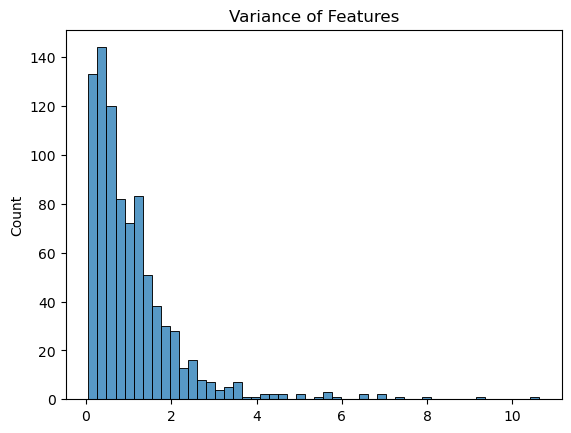

In [16]:
# read data
data = pd.read_csv("../datasets/STATegra/Script_STATegra_proteomics/STATegra_Proteomics_imputed_no_missings_tmm.txt", sep="\t")

# rename columns to unify batch identifier
data.columns = prot_sample_name_transformer(data.columns)

# transpose matrix
data_t = data.T

# show variance in features
feature_variance = data_t.var()
fig, ax = plt.subplots()
sns.histplot(feature_variance, ax=ax)
ax.set_title("Variance of Features")

# remove features with low variance
print(f"Shape before feature selection: {data_t.shape}")

fs_cols = select_feature_above_variance(data_t)
data_t = data_t[fs_cols]

print(f"Shape after feature selection: {data_t.shape}")


# add target columns based on index
data_t["group"] = data_t.index.map(parse_group)
data_t["time"] = data_t.index.map(parse_time)
data_t["time_class"] = data_t.index.map(parse_time_class)

# sort data
data_t = data_t.sort_values(by=['group', 'time'])

# split processed data in to features and target and export

data_features = data_t.iloc[:, 0:-3]

data_features.to_csv("../datasets/STATegra/export_variance_threshold/proteomics.csv")
prot_targets = data_t.iloc[:,-3:]


## Process metabolomics

Shape before feature selection: (36, 58)
Shape after feature selection: (36, 25)


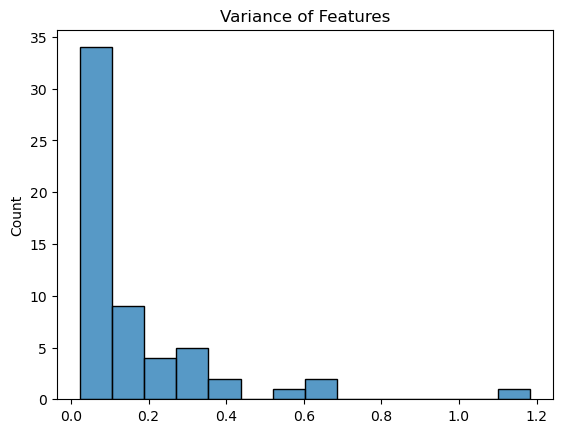

In [17]:
# read data
data = pd.read_csv("../datasets/STATegra/Script_STATegra_Metabolomics/Metabolomics_fused_log_mean_2019.txt", sep="\t")
data.index = data['Metabolite']
data.drop(['Metabolite'], axis=1, inplace=True)

# rename columns to unify batch identifier
data.columns = met_sample_name_transformer(data.columns)

# transpose matrix
data_t = data.T

# show variance in features
feature_variance = data_t.var()
fig, ax = plt.subplots()
sns.histplot(feature_variance, ax=ax)
ax.set_title("Variance of Features")

# remove features with low variance
print(f"Shape before feature selection: {data_t.shape}")

fs_cols = select_feature_above_variance(data_t, variance_threshold=0.1)  
data_t = data_t[fs_cols]

print(f"Shape after feature selection: {data_t.shape}")

# add target columns based on index
data_t["group"] = data_t.index.map(parse_group)
data_t["time"] = data_t.index.map(parse_time)
data_t["time_class"] = data_t.index.map(parse_time_class)

# sort data
data_t = data_t.sort_values(by=['group', 'time'])

# split processed data in to features and target and export

data_features = data_t.iloc[:, 0:-3]

data_features.to_csv("../datasets/STATegra/export_variance_threshold/metabolomics.csv")
met_targets = data_t.iloc[:,-3:]


## Process transcriptomics

Shape before feature selection: (36, 12762)
Shape after feature selection: (36, 1363)


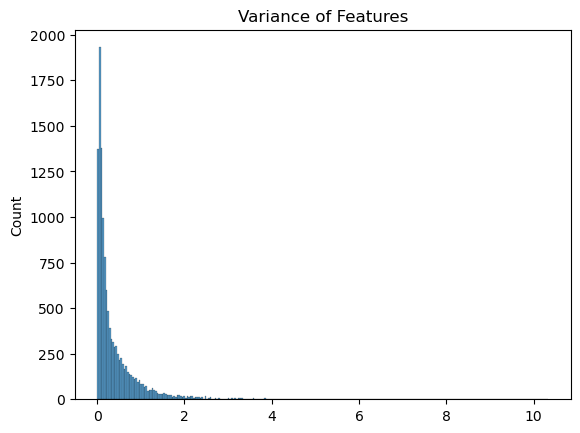

In [18]:
# read data
data = pd.read_csv("../datasets/STATegra/Script_STATegra_RNAseq/RNA_seq/STATegra.RNAseq.CQN.Combat.Annotated.positive_2014_09.csv", sep=",")
data.rename(columns={'Unnamed: 0': 'Transcript'}, inplace=True)
data.index = data['Transcript']
data.drop(['Transcript'],axis=1, inplace=True)

# rename columns to unify batch identifier
data.columns = trans_sample_name_transformer(data.columns)

# transpose matrix
data_t = data.T

# show variance in features
feature_variance = data_t.var()
fig, ax = plt.subplots()
sns.histplot(feature_variance, ax=ax)
ax.set_title("Variance of Features")

# remove features with low variance
print(f"Shape before feature selection: {data_t.shape}")

fs_cols = select_feature_above_variance(data_t, variance_threshold=1)  
data_t = data_t[fs_cols]

print(f"Shape after feature selection: {data_t.shape}")

# add target columns based on index
data_t["group"] = data_t.index.map(parse_group)
data_t["time"] = data_t.index.map(parse_time)
data_t["time_class"] = data_t.index.map(parse_time_class)

# sort data
data_t = data_t.sort_values(by=['group', 'time'])

# split processed data in to features and target and export

data_features = data_t.iloc[:, 0:-3]

data_features.to_csv("../datasets/STATegra/export_variance_threshold/transcriptomics.csv")
trans_targets = data_t.iloc[:,-3:]


## Compare targets of each omics dataset
Check if the samples in each exported omics dataset are in the same order

In [19]:
prot_targets.compare(met_targets)

Empty DataFrame
Columns: []
Index: []

In [20]:
prot_targets.compare(trans_targets)

Empty DataFrame
Columns: []
Index: []

In [21]:
met_targets.compare(trans_targets)

Empty DataFrame
Columns: []
Index: []

Since all are equal, export one target dataframe for later use

In [22]:
prot_targets.to_csv("../datasets/STATegra/export_variance_threshold/targets.csv")